In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.gridspec import GridSpec

import ujson, os

from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel, from_csv
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

useagab()

In [2]:
def hist_means(x_data, y_data, bins):
    bin_means = np.zeros(len(bins)-1)
    for i in np.arange(len(bins)-1):
        left_edge = bins[i]
        right_edge = bins[i+1]
        count = 0
        summed = 0
        
        if right_edge != bins[-1]:
            masked = y_data[(x_data >= left_edge) & (x_data < right_edge)]
        else:
            masked = y_data[(x_data >= left_edge) & (x_data <= right_edge)]
            
        if len(masked) == 0:
            bin_means[i] = np.nan
        else:
            bin_means[i] = np.mean(masked)
        
#         for j, value in enumerate(x_data):            
#             if right_edge != bins[-1]:
#                 if (not value < left_edge) & (value < right_edge):
#                     count += 1
#                     summed += y_data[j]
#             else:
#                 if (not value < left_edge) & (not value > right_edge):
#                     count += 1
#                     summed += y_data[j]
#         if count == 0:
#             bin_means[i] = np.nan
#         else:
#             bin_means[i] = summed/count
    return bin_means


def hist_plotter(values, bins, labelname = '_ignore', loglog=False):
    x_plot_list = []
    y_plot_list = []
    for i in np.arange(len(bins)-1):
        left_edge = bins[i]
        right_edge = bins[i+1]
        x_plot_list.append(left_edge)
        x_plot_list.append(right_edge)
        # Nog delen door de breedte van de bins? --> Maakt het verschil voor nu alleen maar groter
        # binwidth = right_edge-left_edge
        y_plot_list.append(values[i])  # /binwidth)
        y_plot_list.append(values[i])  # /binwidth)
    if loglog == True:
        plt.loglog(x_plot_list, y_plot_list, label=labelname)
    elif loglog == False:
        plt.plot(x_plot_list, y_plot_list, label=labelname, color = 'red')
#     plt.xlim([0, np.max(bins)+1])
#     y_nanless = values[np.invert(np.isnan(values))]
#     plt.ylim([0, np.max(y_nanless)+1])
    plt.legend()
    return


def minmaxrange(dataset, length = 101):
    return np.linspace(np.min(dataset), np.max(dataset), length)

def mean_plotter(x_data, y_data):
    bins = minmaxrange(x_data)
    means = hist_means(x_data, y_data, bins)
    hist_plotter(means, bins)
    return

# mean_plotter(np.array(fgkm_subsample['R_gc'])/1000, np.array(fgkm_subsample['v_phi_gc']))

## Loading in base data

In [3]:
Rsun = 8277.0*u.pc

fgkmtable = load_mwtable('./data/FGKMGoldenSample.fits', Rsun=Rsun, esphs=False)

giants
Number of stars in selected sample: 8274


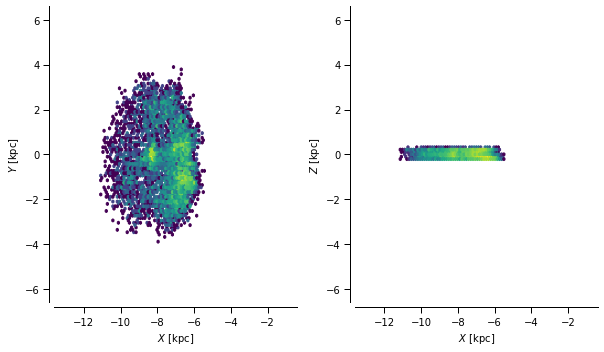

In [9]:
plx_snrlim = 10
vtanhalo = 180.0

plxfilter = fgkmtable['parallax_over_error']>plx_snrlim
zmax = 250

sample_filter_init = plxfilter & (np.abs(np.sin(np.deg2rad(fgkmtable['b']))*1000/fgkmtable['parallax']) < zmax)

R_filter = (fgkmtable['R_gc']>6500.0) & (fgkmtable['R_gc']<15000.0)

no_spt_filter = fgkmtable['source_id'] > 0
giants = fgkmtable['logg_gspphot'] <= 3.0
fstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] > 6000)
gstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 6000) & (fgkmtable['teff_gspphot'] > 5000)
kstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 5000) & (fgkmtable['teff_gspphot'] > 4000)
mstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 4000)

# Choice of stars

filter_dictionary = {
                  'no_spt_filter':no_spt_filter,
                  'giants':giants,
                  'fstars':fstars,
                  'gstars':gstars,
                  'kstars':kstars,
                  'mstars':mstars,
                 }
# Choice of stars
filter_of_choice = "giants"

spt_lum_filter = filter_dictionary[filter_of_choice]
fit_save_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice)


print(fit_save_location[-len(filter_of_choice):])

###

sample_filter = sample_filter_init & spt_lum_filter #& R_filter

print(f"Number of stars in selected sample: {fgkmtable['ra'][sample_filter].size}")

subsample_size = 3000
if (fgkmtable['ra'][sample_filter].size <=subsample_size):
    fgkm_subsample = fgkmtable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(fgkmtable['ra'][sample_filter].size), size=subsample_size, replace=False)
    fgkm_subsample = fgkmtable[sample_filter][random_subsample]
    
plotgrid = [-13, -1, -6, 6]
fig=plt.figure(figsize=(8.5,5), tight_layout=True)

gs = fig.add_gridspec(1, 2, figure=fig)

ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)

ax_xy.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['y_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['z_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

plt.show()

In [5]:
# mean_values_fgkmtable_all = 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


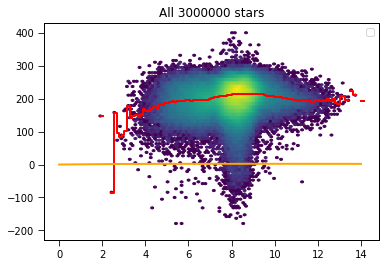

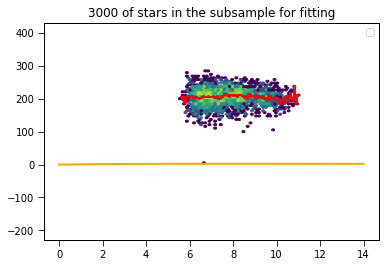

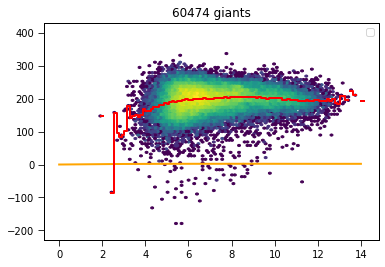

In [11]:
# Plotting the distribution of V_phi for the entire dataset.
plt.hexbin(fgkmtable['R_gc'][no_spt_filter]/1000, fgkmtable['v_phi_gc'][no_spt_filter], bins='log', mincnt=1, extent=[14, 1, -200, 400])
plt.title("All {} stars".format(len(fgkmtable['R_gc'][no_spt_filter])))
mean_plotter(np.array(fgkmtable['R_gc'])/1000, np.array(fgkmtable['v_phi_gc']))
# mincnt=1, , extent=plotgrid

def bp_function(r, p_param, h_param):
    rotcur = lambda x : x/h_param * np.power(1 + (x/h_param)**2, (p_param-2)/4)
    v0 = 3.5#304.0  #km/s
    vc = v0*rotcur(r)
    return v0 * r/h_param * np.power(1 + (r/h_param)**2, (p_param-2)/4)

r = np.linspace(0, 14, 1400)

p_plot = -0.9
h_plot = 5

plt.plot(r, bp_function(r, p_plot, h_plot), color='orange')

plt.figure()
plt.title("{} of stars in the subsample for fitting".format(len(fgkm_subsample['R_gc'])))
plt.hexbin(fgkm_subsample['R_gc']/1000, fgkm_subsample['v_phi_gc'], bins='log', mincnt=1, extent=[14, 1, -200, 400])
plt.plot(r, bp_function(r, p_plot, h_plot), color='orange')
mean_plotter(np.array(fgkm_subsample['R_gc'])/1000, np.array(fgkm_subsample['v_phi_gc']))

plt.figure()
plt.title("{} giants".format(len(fgkmtable['R_gc'][giants])))
plt.hexbin(fgkmtable['R_gc'][giants]/1000, fgkmtable['v_phi_gc'][giants], bins='log', mincnt=1, extent=[14, 1, -200, 400])
plt.plot(r, bp_function(r, p_plot+0.1, h_plot), color='orange')
mean_plotter(np.array(fgkmtable['R_gc'][giants])/1000, np.array(fgkmtable['v_phi_gc'][giants]))


Median d*sin(b): -74.5
RSE d*sin(b): 160.5
Mean d*sin(b): -33.7


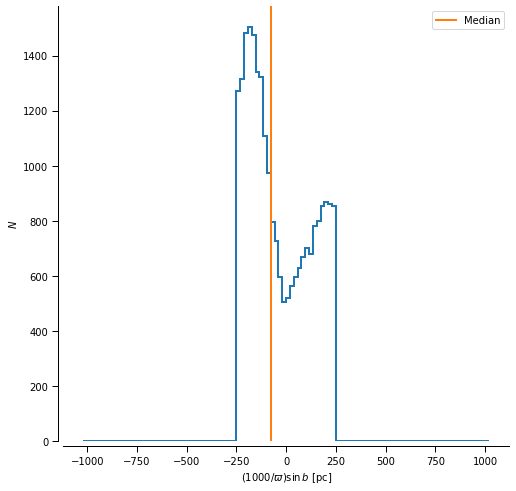

In [7]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(fgkmtable['b']))*1000.0/fgkmtable['parallax'])[sample_filter]
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
zsun = 0.0*u.pc #-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-1020,1020])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

In [ ]:


bins = minmaxrange(fgkmtable['R_gc'][giants])
means = histogram_means(fgkmtable['v_phi_gc'][giants], bins)
histogram_plotter(means, bins)

# Fitting_on_means = True
# 
# if Fitting_on_means == True:
#     fgkm_subsample['l'] = histogram_means(fgkm_subsample['l'], minmaxrange(fgkm_subsample['l']))
#     fgkm_subsample['b'] = histogram_means(fgkm_subsample['b'], minmaxrange(fgkm_subsample['b']))
    
#     Of histogram in de stan file toevoegen.
# Nee ik moet sowieso niet op de mean gaan fitten. De mean plotten was om duidelijkheid te creëeren.

In [8]:
nsources = fgkm_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")

fgkm_data = {'N': nsources, 
            'galon': np.deg2rad(fgkm_subsample['l']).tolist(), 
            'galat': np.deg2rad(fgkm_subsample['b']).tolist(),
            'pml_obs': fgkm_subsample['pml'].tolist(),
            'pml_obs_unc': fgkm_subsample['pml_error'].tolist(),
            'pmb_obs': fgkm_subsample['pmb'].tolist(),
            'pmb_obs_unc': fgkm_subsample['pmb_error'].tolist(),
            'pml_pmb_corr': fgkm_subsample['pml_pmb_corr'].tolist(),
            'plx_obs': fgkm_subsample['parallax'].tolist(),
            'Rsun': Rsun.value,
            'Zsun': zsun.value
            }
with open('fgkm.data.json', 'w') as fp: 
    ujson.dump(fgkm_data, fp)    # R: Converts python object to JSON data format
    fp.close()
    

base_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_1.stan',
                'npars': 7,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

improved_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_2.stan',
                'npars': 8,
                'parnames':['h_param', 'p_param', 'v0', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', 'V_0', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'v0':234.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'v0':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

vdisp_function_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_2_giants_std.stan',
                'npars': 8,
                'parnames':['h_param', 'p_param', 'v0', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy_vector', 'vdispz'],
                'labels':[r'h', r'p', 'V_0', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'v0':234.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':np.nan, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'v0':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

vdisp_function_bp_model_nov0 = {'stanfile':'stanfiles/rotcurve-bp2_2_giants_std_nov0.stan',
                'npars': 7,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy_vector', 'vdispz'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':np.nan, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

vdisp_function_bp2_3_model_nov0 = {'stanfile':'stanfiles/rotcurve-bp2_3_giants_std_nov0.stan',
                'npars': 11,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'A_X', r'A_Y', r'A_Z', r'R_{scale, x}', r'R_{scale, y}', r'R_{scale, z}'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'amplitude_x':80, 'amplitude_y':80, 'amplitude_z':80, 'R_scale_x':1, 'R_scale_y':1, 'R_scale_z':1},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'amplitude_x':np.nan, 'amplitude_y':np.nan, 'amplitude_z':np.nan, 'R_scale_x':np.nan, 'R_scale_y':np.nan, 'R_scale_z':np.nan}
                }

vdisp_function_bp2_3_model_with_v0 = {'stanfile':'stanfiles/rotcurve-bp2_3_giants_std_with_v0.stan',
                'npars': 12,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'v0','amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'V_0', r'A_X', r'A_Y', r'A_Z', r'R_{scale, x}', r'R_{scale, y}', r'R_{scale, z}'],
                'inits':{'h_param':5.0, 'p_param':-0.9, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'v0':234.0, 'amplitude_x':80, 'amplitude_y':80, 'amplitude_z':80, 'R_scale_x':1, 'R_scale_y':1, 'R_scale_z':1},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'v0':np.nan, 'amplitude_x':np.nan, 'amplitude_y':np.nan, 'amplitude_z':np.nan, 'R_scale_x':np.nan, 'R_scale_y':np.nan, 'R_scale_z':np.nan}
                }


vdisp_function_bp2_3_model_with_v0_no_vdisp = {'stanfile':'stanfiles/rotcurve-bp2_3_giants_std_with_v0_no_vdisp2.stan',
                'npars': 6,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'v0'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'V_0'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'v0':234.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'v0':np.nan}
                }

vdisp_function_bp2_3_model_with_v0_classic_vdisp = {'stanfile':'stanfiles/rotcurve-bp2_3_giants_std_with_v0_classic_vdisp.stan',
                'npars': 8,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'v0', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'V_0', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':4.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'v0':234.0, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'v0':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }
                # Deze is nu onlogisch: aanpassen. --> Alleen stanfile moet nog aangepast worden.
#                 no_vdisp.stan is nu een nutteloos bestand (dat was de verkeerde weglating van vdisp)


stan_model = vdisp_function_bp2_3_model_with_v0_classic_vdisp

Number of sources in sample: 3000


In [14]:
print(os.getenv('HOME', "not found")) # Prints "not found"

fgkm_stan = os.path.join(os.getcwd(), stan_model['stanfile'])
#set_cmdstan_path(os.path.join(os.getenv('HOME'), 'cmdstan')) # Does not work on windows
set_cmdstan_path(os.path.join('C:/Users/rjrri/.cmdstan/', 'cmdstan-2.31.0')) # Needs to be replaced with cmdstan location on other Windows devices
fgkm_data_path = os.path.join(os.getcwd(), 'fgkm.data.json')

nwarmup = 500    
nsampling = 1000 # Deze kan omhoog als hij nog niet convergeerd, maar dat wel gaat doen. Hoger dan convergeerwaarde heeft geen zin.
nchains = 4    

fgkm_model = CmdStanModel(stan_file=fgkm_stan)
fgkm_fit = fgkm_model.sample(show_console=False, max_treedepth=10, chains=nchains, iter_warmup=nwarmup, iter_sampling=nsampling, thin=1, data=fgkm_data_path, save_warmup=False, show_progress='notebook', output_dir=fit_save_location)
#fgkm_fit = fgkm_model.sample(chains=4, inits=stan_model['inits'], iter_warmup=500, iter_sampling=1000, thin=1, 
#                           data=fgkm_data_path, save_warmup=False, show_progress='notebook')
# max_treedepth=20,

# init documentation: (=inits in cmdstanpy)
# https://mc-stan.org/cmdstanr/reference/model-method-sample.html 

not found


00:24:18 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

02:42:31 - cmdstanpy - INFO - CmdStan done processing.
02:42:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: gamma_lpdf: Random variable is -1.54553, but must be positive finite! (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/STANFI~1/rotcurve-bp2_3_giants_std_with_v0_classic_vdisp.stan', line 191, column 2 to column 54)
	Exception: gamma_lpdf: Random variable is -1.08831, but must be positive finite! (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/STANFI~1/rotcurve-bp2_3_giants_std_with_v0_classic_vdisp.stan', line 191, column 2 to column 54)
	Exception: gamma_lpdf: Random variable is -0.630779, but must be positive finite! (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/STANFI~1/rotcurve-bp2_3_giants_std_with_v0_classic_vdisp.stan', line 190, column 2 to column 55)
	Exception: gamma_lpdf: Random variable is -0.629186, but must be positive finite! (in 'C:/Users/rjrri/DOCUME~1/UNIVER~1/FIRSTP~1/MILKYW~2/STANFI~1/rotcurve-bp2_3_giants_std_

02:42:40 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 74 divergent transitions (7.4%)
	Chain 2 had 390 iterations at max treedepth (39.0%)
	Chain 3 had 58 divergent transitions (5.8%)
	Chain 4 had 226 divergent transitions (22.6%)
	Use function "diagnose()" to see further information.


In [15]:
import winsound
frequency = 1000  # Set Frequency To 2500 Hertz
duration = 1500  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

Don't forget to erase older .csv and .txt files from the fitfiles folder, when loading the new models.

https://www.wolframalpha.com/input?i=gamma%28alpha%3D1.1%2C+beta%3D10%29
https://mc-stan.org/cmdstanpy/api.html#cmdstanpy.CmdStanModel.sample


In [ ]:
print(fit_save_location)
fgkm_fit.summary()[0:stan_model['npars']+6]

C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants


In [11]:
fgkm_fit.diagnose()

"Processing csv files: C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_with_v0-20230511130522_1.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_with_v0-20230511130522_2.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_with_v0-20230511130522_3.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_3_giants_std_with_v0-20230511130522_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\n877 of 4000 (21.93%) transitions ended with a divergence.\nThese divergent transitions indicate that HMC is not fully able to explore the posterior distribution.\nTry increasing adapt delta cl

In [20]:
print(stan_model['npars'])
print(stan_model['parnames'])
print(len(fgkm_fit.draws()[0,0,:]))  # params?
print(len(fgkm_fit.draws()[0,:,0]))  # Chains
print(len(fgkm_fit.draws()[:,0,0]))  # samples
for i in range(20):
    print(i, len(fgkm_fit.draws()[:,:,i].flatten()))  # All samples over all chains for each parameter.


12
['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'v0', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z']
24030
4
1000
0 4000
1 4000
2 4000
3 4000
4 4000
5 4000
6 4000
7 4000
8 4000
9 4000
10 4000
11 4000
12 4000
13 4000
14 4000
15 4000
16 4000
17 4000
18 4000
19 4000


h_param = 4.0+2.7-4.0
p_param = -0.4+1.5-0.5
Vsun_pec_x = 1.4+17.3-0.5
Vsun_pec_y = 41.0+1.9-41.6
Vsun_pec_z = 2.4+5.4-1.6
v0 = 0.2+2.1-0.2
amplitude_x = 51.1+68.6-47.5
amplitude_y = 27.1+54.7-26.4
amplitude_z = 65.4+3.9-63.6
R_scale_x = 10.0+2205.8-9.2
R_scale_y = 1.7+2.9-1.4
R_scale_z = 6.4+1.7-4.9


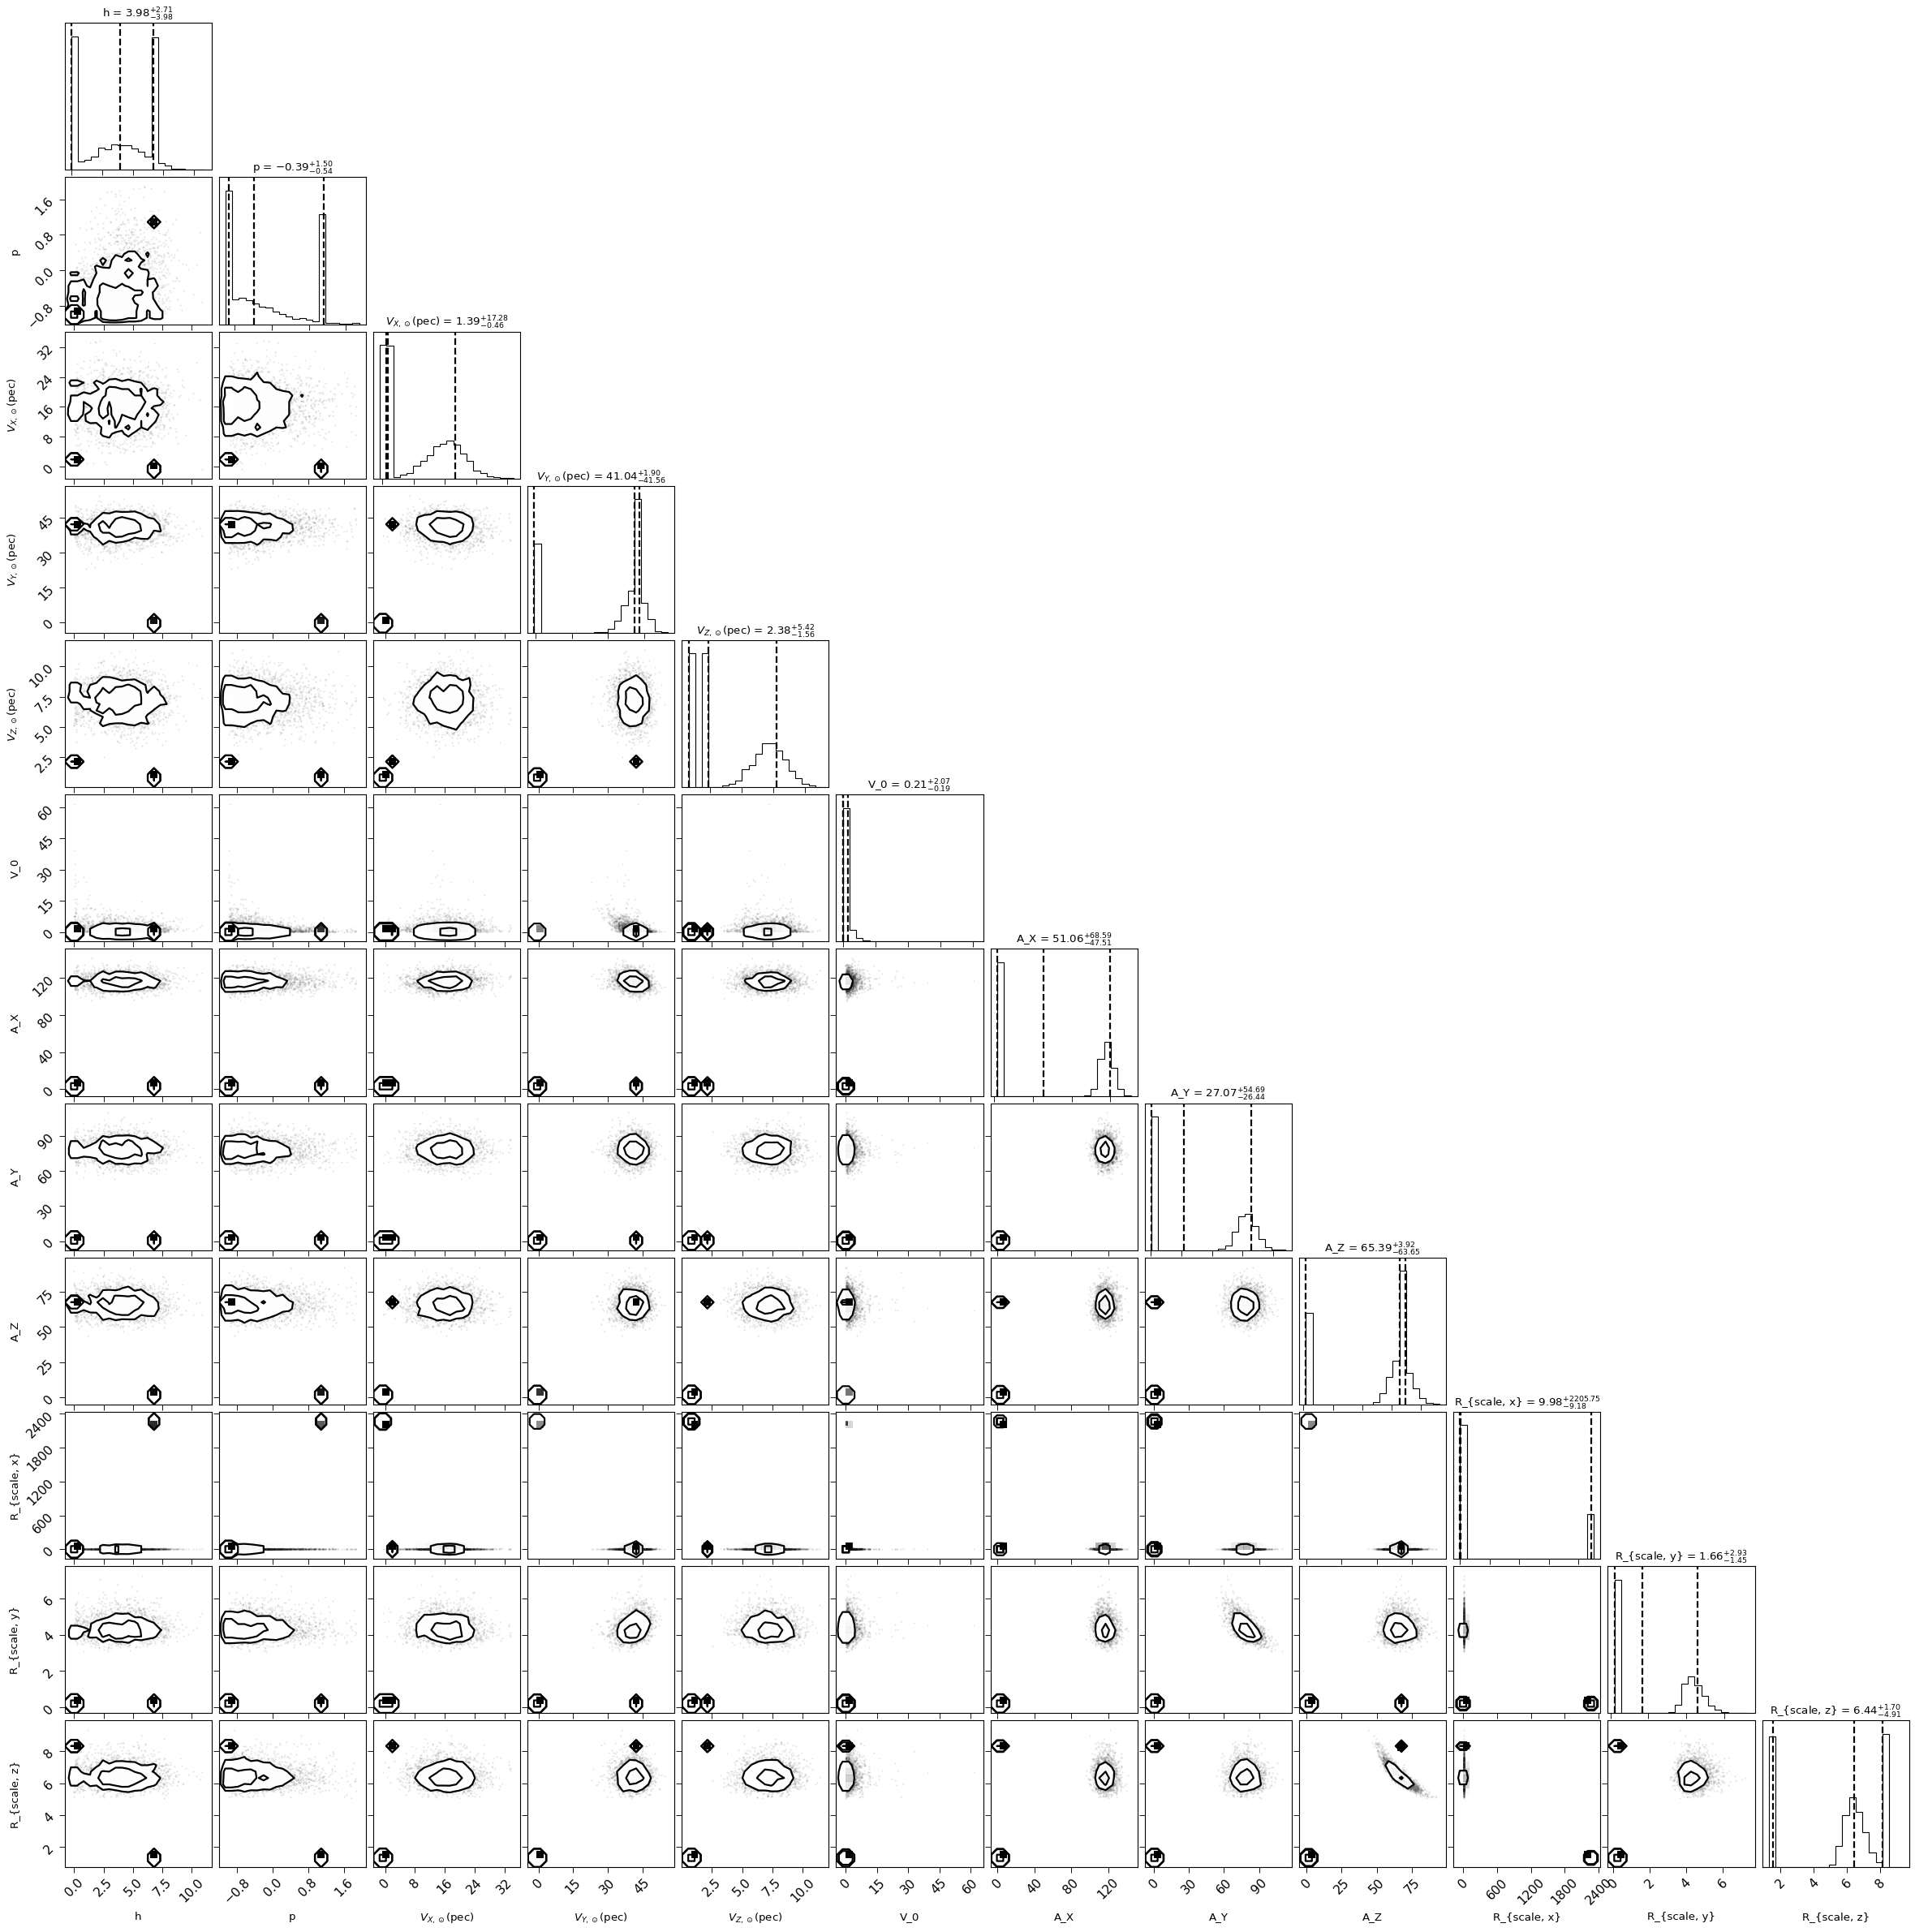

In [50]:
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")

range_number = 7  # Do not change!
sample_lists = []
for i, par in zip(range(range_number, range_number+stan_model['npars']), stan_model['parnames']): # Adjusted the number from 9 to 2 (# of parameters)
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()

useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
# plt.show()

now = datetime.now()
moment_time = now.strftime("%d_%m_%Y__%H_%M_%S")
# plt.savefig('img/Cornerplot_{}.png'.format(moment_time))

In [13]:
print(stan_model['parnames'][0])
print(samples[0])
print(len(sample_lists[0]))
print(len(samples))
print(len(sample_lists))
print(len(sample_lists[0][sample_lists[0]<0]))  # Samples for h < 0. This should not be possible.

h_param
[-1.12969    0.482443   0.165838   0.32226    1.02225    0.396967
  0.274868  -0.0563779 -0.0779979 -0.0746444 -0.0900717  0.0024961]
4000
4000
12
1000


['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'v0', 'amplitude_x', 'amplitude_y', 'amplitude_z', 'R_scale_x', 'R_scale_y', 'R_scale_z']
h_param = 2.3+16.0-2.0
p_param = 1.3+21.2-7.0
Vsun_pec_x = 16.5+0.1-12.3
Vsun_pec_y = 0.9+30.2-1.4
Vsun_pec_z = 5.3+0.6-3.5
v0 = 1.2+13.9-158.2
amplitude_x = 0.3+2.9-0.1
amplitude_y = 69.3+378.5-68.4
amplitude_z = 1.0+2.1-0.7
R_scale_x = 0.4+0.4-0.2
R_scale_y = 34.1+3921.6-33.7
R_scale_z = 0.3+1.4-0.0


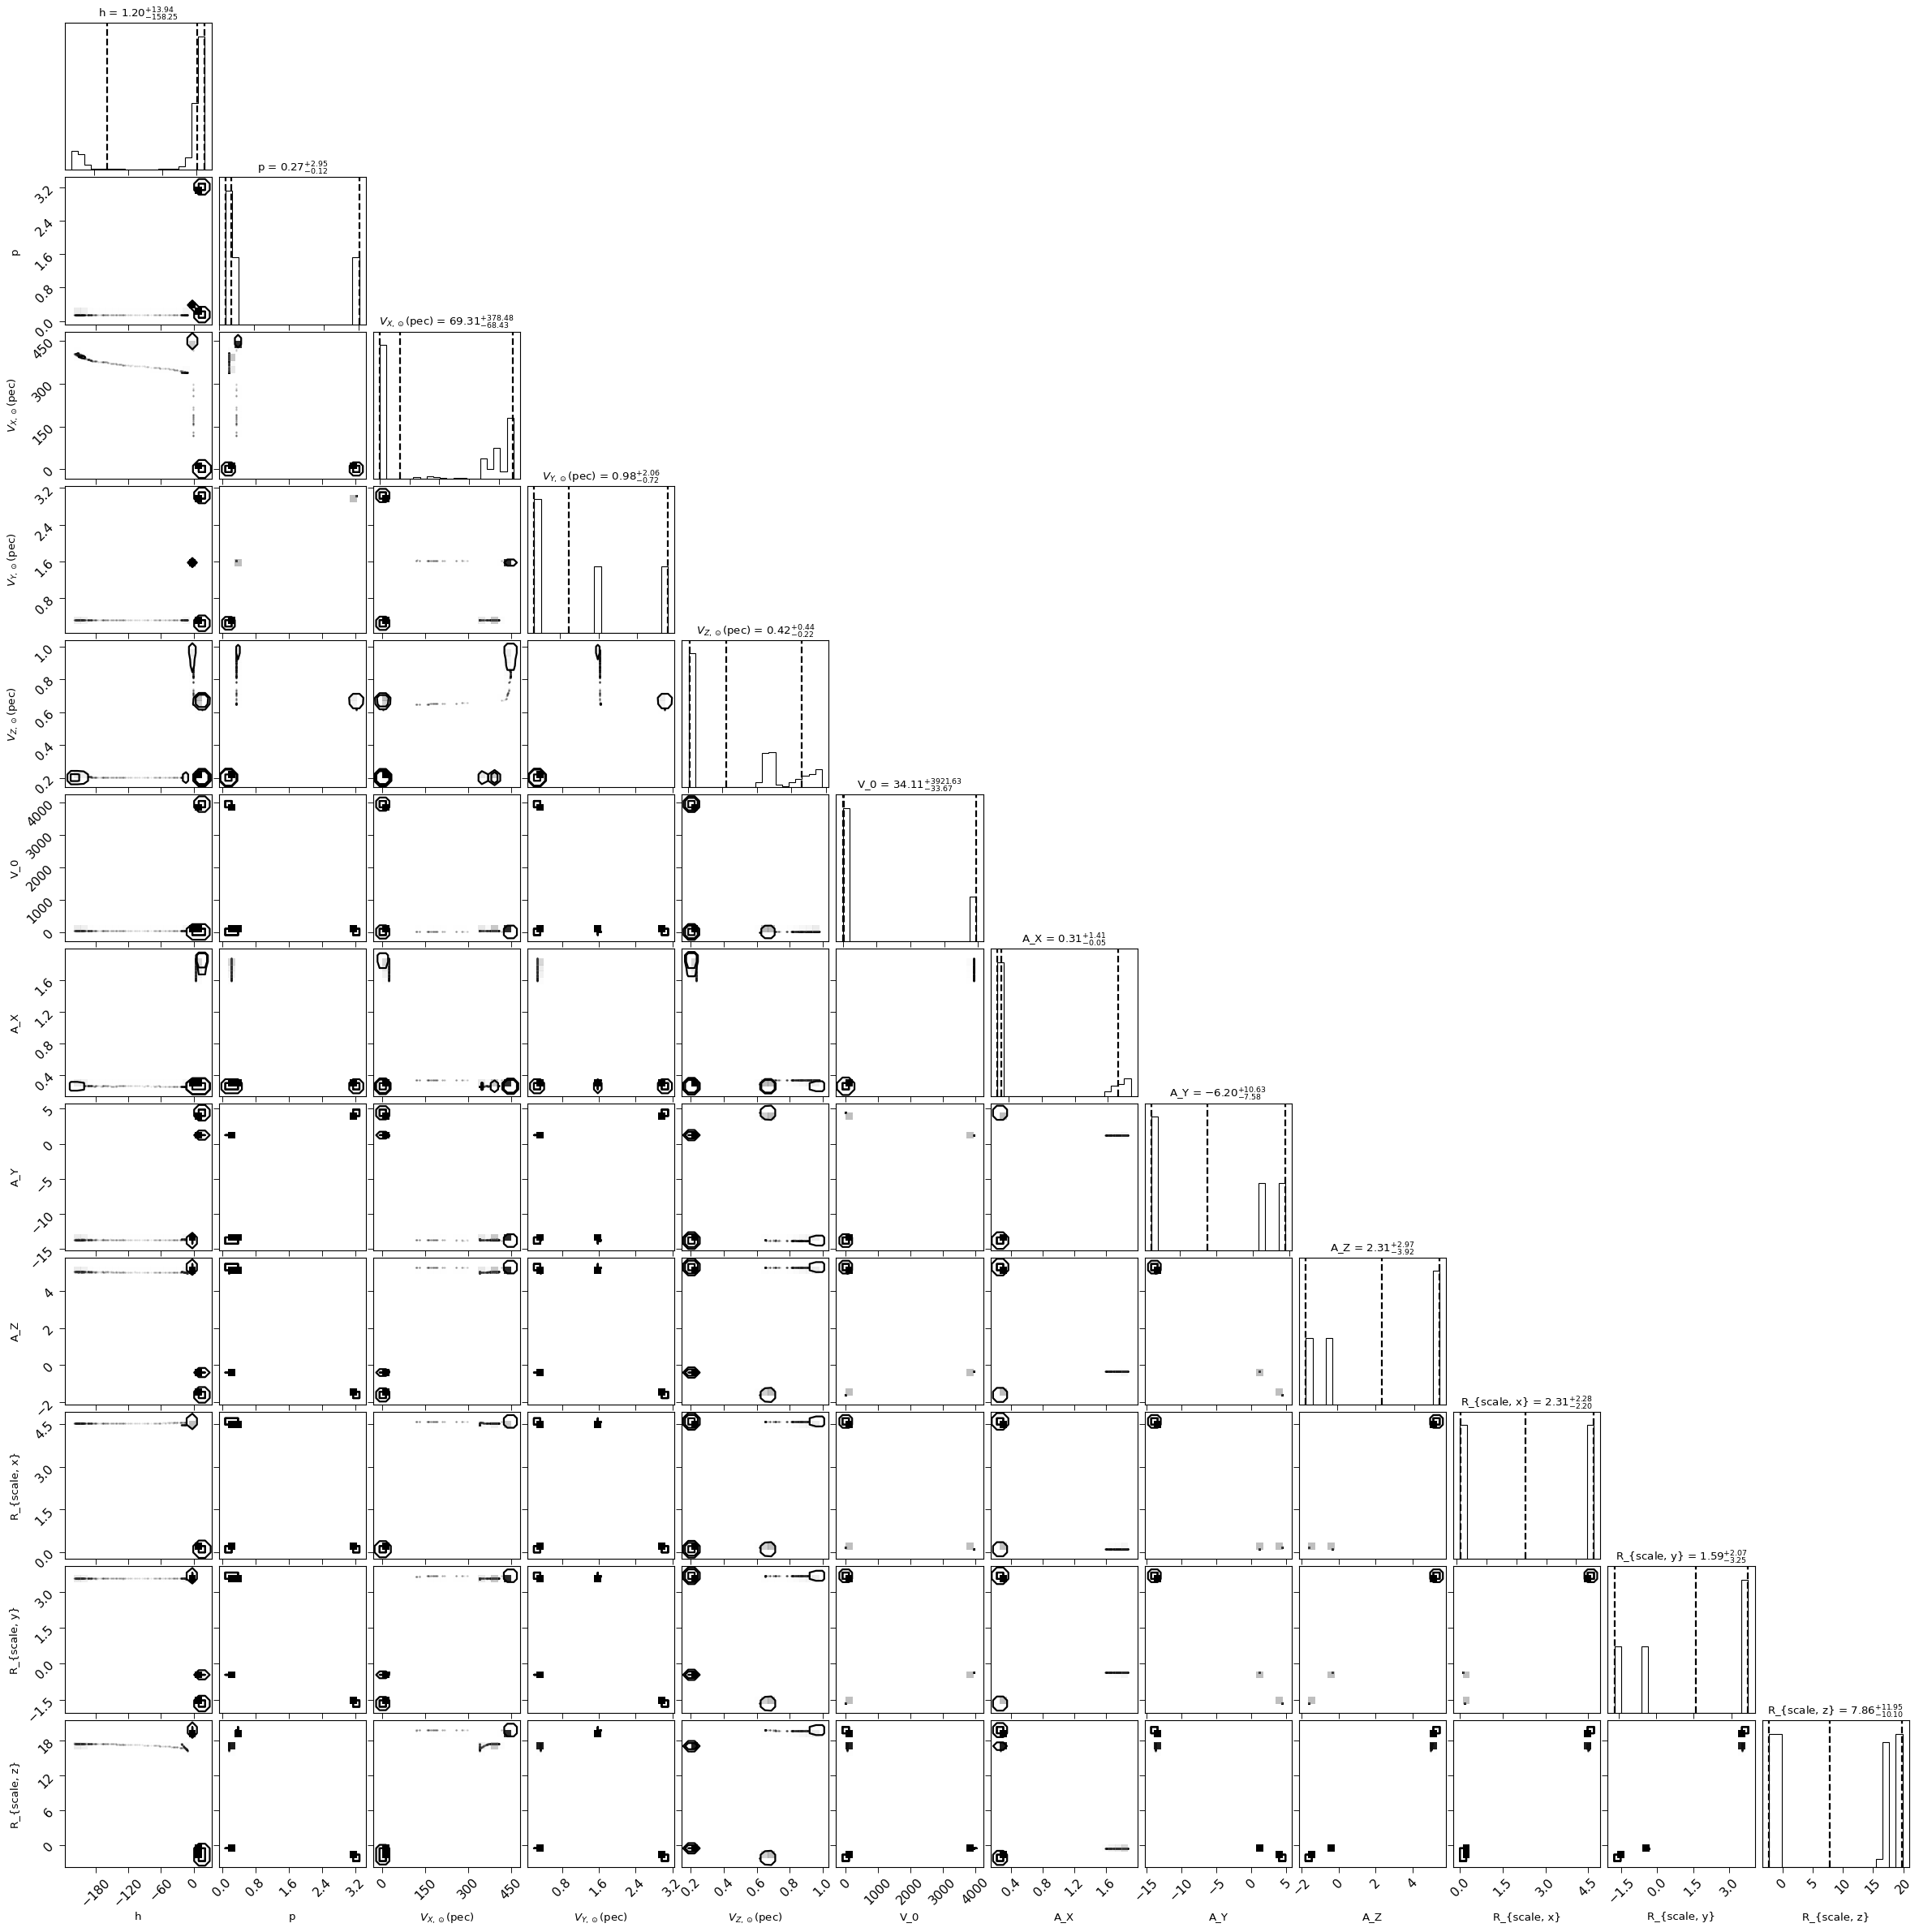

{'h_param': 2.314625, 'p_param': 1.3123225, 'Vsun_pec_x': 16.4874, 'Vsun_pec_y': 0.9433054999999999, 'Vsun_pec_z': 5.3068, 'v0': 1.1994000000000002, 'amplitude_x': 0.273624, 'amplitude_y': 69.31465, 'amplitude_z': 0.976763, 'R_scale_x': 0.42313300000000004, 'R_scale_y': 34.1061, 'R_scale_z': 0.3115}
12
[array([   3.89076,   -1.50594,   15.1409 , ...,   -1.49182,   15.1408 ,
       -212.687  ]), array([0.216466, 0.330885, 3.21877 , ..., 0.345112, 3.22008 , 0.153002]), array([ 21.7534  , 116.85    ,   0.882531, ..., 448.644   ,   0.882519,
       405.894   ]), array([0.25918 , 1.62911 , 3.03832 , ..., 1.62313 , 3.03828 , 0.326582]), array([0.230834, 0.648674, 0.615407, ..., 0.97884 , 0.677448, 0.208117]), array([3.95565e+03, 2.26127e+01, 4.31618e-01, ..., 2.30163e+01,
       4.31661e-01, 4.75623e+01]), array([1.59294 , 0.335878, 0.28834 , ..., 0.335006, 0.288345, 0.259304]), array([  1.2132 , -13.734  ,   4.42685, ..., -13.8123 ,   4.42682,
       -13.6739 ]), array([-0.345378,  5.2697  

In [23]:
print(stan_model['parnames'])
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")

sample_lists = []
for i, par in zip(range(12, 12+stan_model['npars']), stan_model['parnames']): # Adjusted the number from 9 to 2 (# of parameters)
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()

useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()

# Number of draws is very low
print(stan_model['best_params'])
print(len(sample_lists))
print(sample_lists)
print(samples)
print(len(samples)) # 4000 samples

print("h_init = 3!")

## Using an exponential function to model the dispersion of the giants in x, y and z

In [14]:
def exponential_function(R, amplitude, R_scale):
    return amplitude * np.exp(-(R-2.5)/R_scale)

In [17]:
xxx = np.linspace(0, 14)
amplitude = 80
R_scale = 10
for i in range(len(xxx)):
    if xxx[i] < 2.5:
        yyy[i] = amplitude
    else:
        yyy[i] = exponential_function(xxx[i], amplitude, R_scale)

(0.0, 90.0)

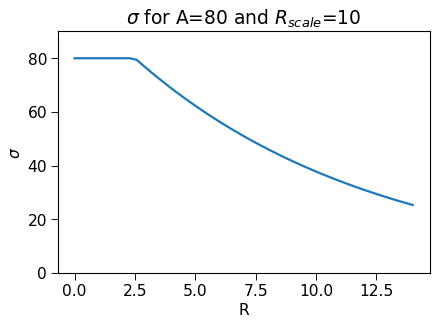

In [18]:
plt.plot(xxx, yyy)
plt.title('$\sigma$ for A={} and $R_{}$={}'.format(amplitude, '{scale}', R_scale))
plt.xlabel('R')
plt.ylabel('$\sigma$')
plt.ylim(0,90)

## Finding the correct formula for the dispersion of the giants

y_max at: 0.10599098256719744
at x=2.5, y= 75.62337832983363


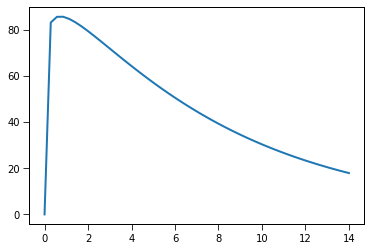

In [11]:
# alpha = 1.1 --> beta = 7.12789
# exp(10/b)/(11^(a-1)) = 80/25 in wolfram alpha
xxx = np.linspace(0, 14)
yyy = 808.69*0.121172*np.exp(-0.140294*xxx)*xxx**0.1
print("y_max at:", 0.121172*np.exp(-0.140294*(50000/70147))*(50000/70147)**0.1)
print("at x=2.5, y=", 808.69*0.121172*np.exp(-0.140294*2.5)*2.5**0.1)
plt.plot(xxx, yyy)
plt.show()
# Still a bit too low

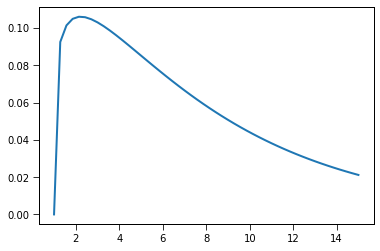

In [13]:
# alpha = 1.2 --> beta = 6.08743
# exp(10/b)/(11^(a-1)) = 80/25 in wolfram alpha
xxx = np.linspace(0, 14)
yyy = 0.124668*np.exp(-0.164273*x)*x**0.2
plt.plot(xxx+1, yyy)
plt.show()
# Still a bit too low

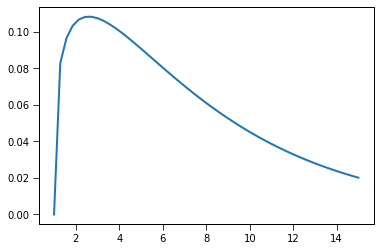

In [14]:
# alpha = 1.3 --> beta = 5.31203
# exp(10/b)/(11^(a-1)) = 80/25 in wolfram alpha
xxx = np.linspace(0, 14)
yyy = 0.127099*np.exp(-0.188252*x)*x**0.3
plt.plot(xxx+1, yyy)
plt.show()
# Meh

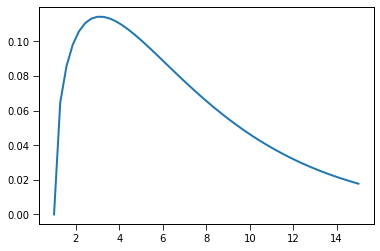

In [15]:
# alpha = 1.5 --> beta = 4.23352
# exp(10/b)/(11^(a-1)) = 80/25 in wolfram alpha
xxx = np.linspace(0, 14)
yyy = 0.12954*np.exp(-0.23621*x)*x**0.5
plt.plot(xxx+1, yyy)
plt.show()
# Slechter

In [ ]:
# Ik heb voor nu alpha = 1.1 en bijhorende beta = 7.12789 gekozen.